Caroline HOANG

# Deep Probabilistice Generative Models - Variational Auto-Encoders

## 0. Preprocessing

In [ ]:
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F

import os
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib
import math

# To load the data we will use the script of Gaetan Marceau Caron
# You can download it from the course webiste and move it to the same directory that contains this ipynb file
import dataset_loader

%matplotlib inline

Next, we download and preprocess the MNIST dataset, see http://yann.lecun.com/exdb/mnist/ .
Our observed random variables will be Bernoulli distributions, so we need to binarize the dataset, i.e. each pixel can either be black or white.

In [ ]:
# Download mnist dataset
if("mnist.pkl.gz" not in os.listdir(".")):
    !python -m wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

# the dataset contains 3 splits (train/dev/test),
# each one containing two vectors (pixels and classes)
(train_data_pixels, train_data_classes), \
(dev_data_pixels, dev_data_classes), _ = dataset_loader.load_mnist(mnist_path)

In [ ]:
# to binarize, we just set to 1 pixels with a value >= 0.5, 0 otherwise
train_data_pixels = 1*(train_data_pixels >= 0.5)
dev_data_pixels = 1*(dev_data_pixels >= 0.5)

In [ ]:
# dataset_loader return numpy tensors,
# we convert them directly to pytorch tensors
train_data_pixels = torch.from_numpy(train_data_pixels).float()
train_data_classes = torch.from_numpy(train_data_classes).long()

dev_data_pixels = torch.from_numpy(dev_data_pixels).float()
dev_data_classes = torch.from_numpy(dev_data_classes).long()

In [ ]:
# there 50000 images, each image is of size 28x28
#Â each image as been reshaped as vector of size 784
print("Shape of the pixel tensor:", train_data_pixels.shape)
print("Shape of the class tensor:", train_data_classes.shape)

Shape of the pixel tensor: torch.Size([50000, 784])
Shape of the class tensor: torch.Size([50000])


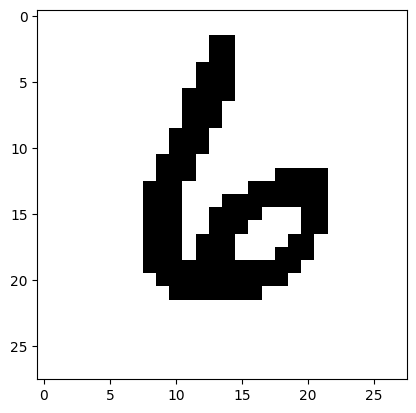

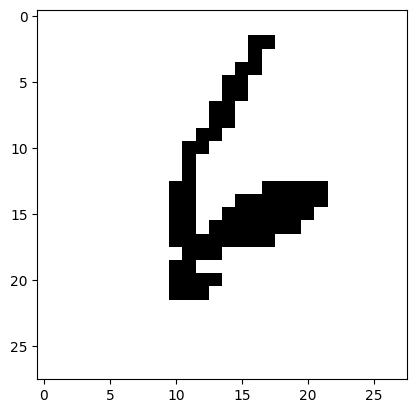

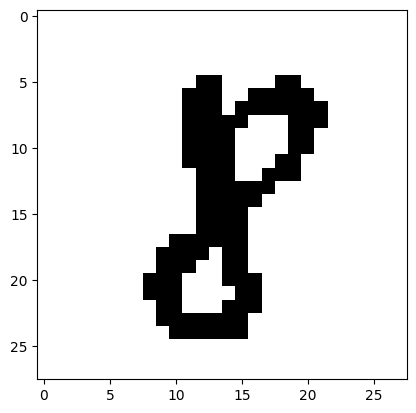

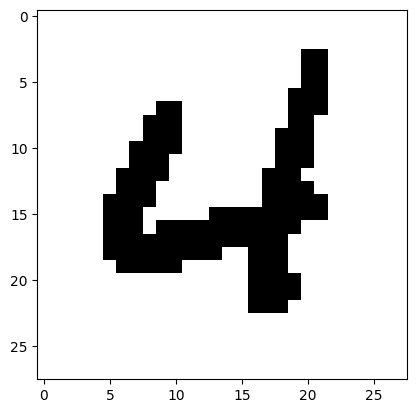

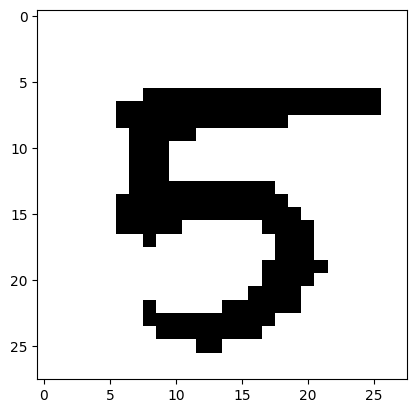

In [ ]:
# we will use this function to print images generated by our network
# the parameter images must be a tensor of shape (n images, 784)
def display_images(images):
    # convert to numpy tensor
    images = images.detach().numpy()
    for i in range(images.shape[0]):
        plt.imshow(images[i].reshape(28,28), cmap='Greys')
        plt.show()

# display the 5 first image in the dataset
display_images(train_data_pixels[:5])

## 1. MNIST classification with Pytorch

The function computed by this network

Let $A^{(1)} = (a^{(1)}_{i,j})_{1 \leq i \leq hidden\_dim, 1 \leq j \leq 784}$, $A^{(2)} = (a^{(2)}_{i,j})_{1 \leq i \leq output\_dim, 1 \leq j \leq hidden\_dim}$, $b^{(1)}$ and $b^{(2)}$ respectively the parameters of the first and second projection, associated with the first and second linear layer.

Let $x$ be the input vector, $y$ the output vector and $z$ a hidden representation.
Let $\delta$ be a sample from the Bernoulli distribution $\mathcal{B}(0.5)$.

We have :

$z = \left (x \times A^{(1)T} + b^{(1)} \right )^{+}$

$y = (z \star \delta) \times A^{(2)T} + b^{(2)}$

with $\star$ the convolution operator.

The reLu layer takes the maximum between each value and 0, i.e. :
$hid = max(input\_matrix \times W + b, 0)$


- what are the dimensions of each parameter?

batch : $n \times 784 \times output\_dim = n \times 784 \times 10$

input\_dim : $n \times 784$ when called in forward

hidden\_dim : $10$

output\_dim : $10$

hid : $n \times hidden\_dim = n \times output\_dim = n \times 10$

In [ ]:
m = nn.Linear(784, 30)
input = torch.randn(1, 784)
output = m(input)
print(output.size())

torch.Size([1, 30])


In [ ]:
# to create a neural network (or a part of a neural network),
# we create a class that extends nn.Module
class Classifier(nn.Module):
    # the constructor, parameters are self-documented by their name :)
    # input_dim: in our case it will the size of a single input image
    # hidden_dim: the hidden representation dim
    # output_dim: the number of class, in our case there are 10 digits
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_ratio=0.5):
        super().__init__()

        # we have two projections in the network,
        # the first one project the input in the hidden space,
        # the second one project the hidden representation in the output space.
        # have a look at the documentation of nn.Linear!
        # nn.Linear extends nn.Module
        self.proj1 = nn.Linear(input_dim, hidden_dim)
        self.proj2 = nn.Linear(hidden_dim, output_dim)

        # dropout can be used to prevent overfitting,
        # however, it may be better to start training VAE without!
        # I just put it here for the example

        # let assume you create a network with:
        # network = Classifier(10, 10, 10)
        # then, to enable dropout you must call:
        # network.train()
        # and to disable dropout:
        # network.eval()
        # basically this calls set the network
        # in training and evaluation modes, respectively
        self.dropout = nn.Dropout(0.5)

    # this is the function that will be called
    # when we pass data to the network to compute the output
    # shape of batch: (n samples, output_dim)
    # where n samples is the number of samples in the batch
    def forward(self, batch):
        hid = self.proj1(batch)

        # non-linearity, it could have been a nn.Module object stored in this module,
        # here we use the functionnal version
        hid = F.relu(hid)

        # note: dropout is used to prevent overfitting
        hid = self.dropout(hid)

        # return the output, i.e. logits of each class for each sample in the batch
        # shape: (n samples, output_dim)
        return self.proj2(hid)

In [ ]:
n_epoch = 20
batch_size = 100

# build the network!
network = Classifier(28*28, 200, 10)

# optimizer that will be used to update the parameters!
optimizer = torch.optim.Adam(network.parameters())

all_epoch_losses = list()
all_epoch_accuracies = list()
for epoch in range(n_epoch):
    # we keep track of the loss at each epoch
    epoch_loss = 0

    # Note: one trick often used is to shuffle the data at each epoch,
    # we won't do that here.
    # if you want to do it, be carefull:
    # you need to shuffle both train_data_pixels and train_data_classes
    # so that they match, i.e. you cannot shuffle them independently!

    network.train() # set the network in train mode (i.e. enable dropout)

    # loop over the data
    for i in range(0, train_data_pixels.shape[0], batch_size):
        # IMPORTANT:
        # we must always call zero_grad() because each call to .backward()
        # will accumulate the gradient!
        optimizer.zero_grad()

        # batch of data
        # shape: (n samples, 784)
        # do you understand why n samples can be different of batch_size?
        batch = train_data_pixels[i:i+batch_size]

        # compute the weights associate with each class for each picture
        # logits shape: (n samples, 10)
        logits = network(batch)

        # compute the loss
        # look at the documentation of the function!
        loss = F.cross_entropy(
            logits,
            train_data_classes[i:i+batch_size],
            reduction="mean"
        )

        # to accumulate to the epoch loss,
        # we need to call loss.item() so the value
        # will detached from the computational graph,
        # i.e. loss.item() is python float, not a pytorch object.
        # can you understand why we multiply by batch_size.shape[0] ?
        epoch_loss += loss.item() * batch.shape[0]

        loss.backward() # compute the gradient
        optimizer.step() # update parameters of the model

    # at the end of each epoch, we eval on the dev data
    network.eval()
    n_dev_correct = 0

    # we don't need gradient computation during evaluation,
    # so we enclose computation with torch.no_grad(),
    # this will makes computation more efficient
    with torch.no_grad():
        for i in range(0, dev_data_pixels.shape[0], batch_size):
            batch = dev_data_pixels[i:i+batch_size]
            logits = network(batch)

            # compute the class of maximum weight for each sample,
            # look at the documentation of argmax!
            # pred shape: (n samples,)
            pred = logits.argmax(1)

            # compare prediction with gold classes
            n_dev_correct += (pred == dev_data_classes[i:i+batch_size]).sum().item()

    all_epoch_losses.append(epoch_loss)
    all_epoch_accuracies.append(n_dev_correct / dev_data_classes.shape[0])
    print(
        epoch, ":\t",
        epoch_loss,# / len(train_data[0]),
        "\t / dev precision:\t",
        n_dev_correct / dev_data_classes.shape[0],
        flush=True
    )

0 :	 24491.13413244486 	 / dev precision:	 0.9397
1 :	 12377.093935757875 	 / dev precision:	 0.9552
2 :	 9636.46450266242 	 / dev precision:	 0.9627
3 :	 8291.617211326957 	 / dev precision:	 0.9651
4 :	 7013.311477936804 	 / dev precision:	 0.9679
5 :	 6173.8887855783105 	 / dev precision:	 0.9707
6 :	 5778.960554301739 	 / dev precision:	 0.9701
7 :	 5229.671191051602 	 / dev precision:	 0.9728
8 :	 4811.449814774096 	 / dev precision:	 0.9732
9 :	 4439.696670882404 	 / dev precision:	 0.9724
10 :	 4188.968706689775 	 / dev precision:	 0.9742
11 :	 3914.2218947410583 	 / dev precision:	 0.9732
12 :	 3571.438309084624 	 / dev precision:	 0.9738
13 :	 3372.360542882234 	 / dev precision:	 0.9752
14 :	 3311.4263981580734 	 / dev precision:	 0.9759
15 :	 3186.037943791598 	 / dev precision:	 0.9752
16 :	 3054.046947741881 	 / dev precision:	 0.9754
17 :	 2944.6700455155224 	 / dev precision:	 0.9762
18 :	 2738.8315656222403 	 / dev precision:	 0.9765
19 :	 2495.262337755412 	 / dev prec

ValueError: ignored

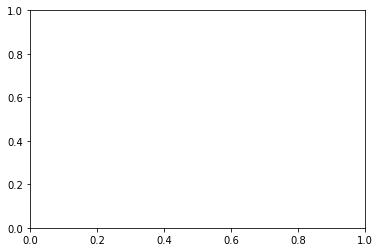

In [ ]:
# print graph to show how the loss and the accuracy evolve during training,
# for example to see if we overfit the training data.
# Note that MNIST is a really simple dataset, so its no really interesting in this case :)
plt.plot(np.arange(n_epoch), all_epoch_losses)
plt.show()

plt.plot(np.arange(n_epoch), all_epoch_accuracies)
plt.show()

## 2. VAE with continuous latent space and binary observed space

The first VAE that we will develop is based on the following generative story:

1. $z \sim p(z)$
2. $x \sim p(x | z ; \theta)$

where the latent random variable $Z$ takes value in $\mathbb R^n$.
The prior ditribution $p(z)$ is a multivariate Gaussian where each coordinate is independent.
We fix the mean and variance of each coordinate to 0 and 1, respectively.
The conditional distribution $p(x | z ; \theta)$ is parameterized by a neural network.
The random variables $X$ are $m$ independent Bernoulli random variables.

Note: this kind of VAE will be quite bad at generating MNIST picture.
Therefore, when you do you experiments, you should both generate picture and show the distribution $p(x | z ; \theta)$ as a picture.
This is a well known problem of VAE, you can try to play with the network architecture and the parameters to improve generation.
However, hyperparameter optimization is not the goal of this lab exercise. :)
Another solution would be to use Gaussian random variables for the output distribution, but we won't do that here.

### KL divergence

The first function we have to implement is the one that compute the KL divergence with the prior.
You can find the formula in appendix B of the following paper: https://arxiv.org/pdf/1312.6114.pdf

**WARNING:** In the paper they give the formula for the -KL, and here we want the KL, so don't forget to put a minus sign in front of their formula. :)

In [ ]:
# the shapes of mu and log_sigma_squared are: (n batch, n latent)
# the return vector must be of shape: (n batch,)
def KL_with_gaussian_prior(mu, log_sigma_squared):
    n = log_sigma_squared.size(dim=0);
    J = log_sigma_squared.size(dim=1);
    KL = torch.zeros(n);
    for i in range(0, n):
        s = 0;
        for j in range(0, J):
            s += 1 + log_sigma_squared[i, j].item() - mu[i, j].item()**2 - np.exp(log_sigma_squared[i, j].item())
        KL[i] = 0.5 * s
    return -KL

# test for shape
mu = torch.rand((10, 30))
log_sigma_squared = torch.rand((10, 30))

if KL_with_gaussian_prior(mu, log_sigma_squared).shape != (10,):
    raise RuntimeError("Invalid return dim!")
else:
    print("return dim is ok.")

# test for return value
# result should be 0 as it is equal to the prior
print("Should be 0:", KL_with_gaussian_prior(torch.tensor([[0.]]), torch.tensor([[0.]])).item())
print("Should be 0.5:", KL_with_gaussian_prior(torch.tensor([[1.]]), torch.tensor([[0.]])).item())
print("Should be 2.6945...:", KL_with_gaussian_prior(torch.tensor([[1.]]), torch.tensor([[2.]])).item())

return dim is ok.
Should be 0: -0.0
Should be 0.5: 0.5
Should be 2.6945...: 2.694528102874756


### Network

Next you need to code the encoder and the decoder.
The encoder should return a tuple of tensors (mu, log_sigma_squared),
both are unconstrained so they should be the output of a linear projection.
The term log_sigma_squared means that the standard deviation can be computed via sigma=exp(0.5 * log_sigma_squared).
Be sure you understand this.

The structure of the encoder should be as follow:

- one projection and non linearity (e.g. relu) to compute a hidden representation of the input,
- two projections to compute my and log_sigma_squared from the same hidden representation.

The structure of the decoder shoud be similar to the classifier above.
Similarly to the encoder, the decoder should output unconstrained value, i.e. it does not directly return the mu parameters of the Bernoulli distribution, but values in R.
In your code, if you need to get the distribution, you can call sigmoid(mu) to transform the unconstrained values to the mu parameters.

- one projection and non linearity (e.g. relu) to compute a hidden representation of the input,
- one projection to the output space

The decode has two additional functions:

- sample_distributions: it samples from the prior and return the conditional output distributions (so here it means that you **must** apply the sigmoid befaire returning)
- sample_images: call sample_distributions and then sample images from the output distributions.

To sample from a Bernoulli you can use the following function: https://pytorch.org/docs/stable/generated/torch.bernoulli.html
To sample from the Gaussian prior, you can:

- first create an empty tensor via https://pytorch.org/docs/stable/generated/torch.empty.html
- then fill values in the tensor via https://pytorch.org/docs/stable/tensors.html#torch.Tensor.normal_

This second function change a tensor in-place (hence the _ at the end of the name)

In [ ]:
class GaussianEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(GaussianEncoder, self).__init__()
        self.proj1 = nn.Linear(input_dim, hidden_dim)
        #self.proj2 = nn.Linear(hidden_dim, hidden_dim)
        self.proj_mean = nn.Linear(hidden_dim, latent_dim)
        self.proj_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, batch):
        hid = self.proj1(batch)
        hid = F.relu(hid)
        #hid = self.proj2(hid)
        hid = F.relu(hid)

        mu = self.proj_mean(hid)
        logvar = self.proj_logvar(hid)

        return mu, logvar


In [ ]:
class GaussianPriorDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.proj1 = nn.Linear(input_dim, hidden_dim)
        #self.proj2 = nn.Linear(hidden_dim, hidden_dim)
        self.proj3 = nn.Linear(hidden_dim, output_dim)
        self.input_dim = input_dim
        self.output_dim = output_dim

    def forward(self, batch):
        hid = self.proj1(batch)
        hid = F.relu(hid)
        #hid = self.proj2(hid)
        #hid = F.relu(hid)
        return self.proj3(hid)

    # n_samples: number of "image output distribution" to compute
    def sample_distributions(self, n_samples):
        # first you must sample from the prior,
        # then you must pass the data through this network, i.e. self(z)
        # shape of z: (n_samples, input_dim)
        z = torch.empty(n_samples, self.input_dim)
        z=torch.normal(z)
        res = self(z)
        sigmoid = nn.Sigmoid()
        return sigmoid(res)



    # sample images
    def sample_images(self, n_samples, argmax=False):
        # compute the output distributions for each image
        # probs shae: (n_samples, output_dim)
        probs = self.sample_distributions(n_samples)

        # then sample output pixels
        # there are two modes:
        # argmax=False: sample from the output distribution
        # argmax=True: instead of sampling, return the most probable value for each random variable
        # (check how the images are converted to binary images above!)
        if argmax == False:
            return torch.bernoulli(probs)
        else:
            result = torch.zeros(probs.size(dim=0), probs.size(dim=1))
            for i in range(0, probs.size(dim=0)):
                for j in range(0, probs.size(dim=1)):
                    result[i, j] = 1*(probs[i,j].item() >= 0.5)
            return result

        # to binarize, we just set to 1 pixels with a value >= 0.5, 0 otherwise
        #train_data_pixels = 1*(train_data_pixels >= 0.5)
        #dev_data_pixels = 1*(dev_data_pixels >= 0.5)

In [ ]:
class GaussianPriorDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GaussianPriorDecoder, self).__init__()
        self.proj1 = nn.Linear(input_dim, hidden_dim)
        self.proj2 = nn.Linear(hidden_dim, hidden_dim)
        self.proj3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, batch):
        hid = F.relu(self.proj1(batch))
        hid = F.relu(self.proj2(hid))
        return self.proj3(hid)

    def sample_distributions(self, n_samples):
        # Sample from a standard normal distribution
        z = torch.randn(n_samples, self.proj3.in_features)
        res = self(z)
        return res

    def sample_images(self, n_samples, argmax=False):
        # Compute the output distributions for each image
        probs = self.sample_distributions(n_samples)

        # Sample output pixels
        if argmax:
            result = (probs >= 0.5).float()  # Binarize based on a threshold
        else:
            result = torch.bernoulli(torch.sigmoid(probs))  # Use sigmoid for sampling

        return result


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GaussianEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(GaussianEncoder, self).__init__()
        self.proj1 = nn.Linear(input_dim, hidden_dim)
        self.proj2_mean = nn.Linear(hidden_dim, latent_dim)
        self.proj2_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, batch):
        hid = F.relu(self.proj1(batch))
        mu = self.proj2_mean(hid)
        logvar = self.proj2_logvar(hid)
        return mu, logvar

class GaussianPriorDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GaussianPriorDecoder, self).__init__()
        self.proj1 = nn.Linear(input_dim, hidden_dim)
        self.proj2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, batch):
        hid = F.relu(self.proj1(batch))
        return self.proj2(hid)

    def sample_distributions(self, n_samples):
        # Sample from a standard normal distribution
        z = torch.randn(n_samples, self.proj1.in_features)
        res = self(z)
        return torch.sigmoid(res)

    def sample_images(self, n_samples, argmax=False):
        # Compute the output distributions for each image
        probs = self.sample_distributions(n_samples)

        # Sample output pixels
        if argmax:
            result = (probs >= 0.5).float()  # Binarize based on a threshold
        else:
            result = torch.bernoulli(probs)  # Use Bernoulli sampling

        return result

In [ ]:
z = torch.empty(5, 2).uniform_(0, 1)
torch.normal(z)

tensor([[ 1.3117,  1.0187],
        [ 1.2811,  0.5244],
        [-0.5710,  0.2993],
        [-0.0492,  2.3218],
        [ 0.5088,  0.6791]])

### Training loop

I did most of the work, you just need to implement ont thing: the reparameterization trick! :)

In [ ]:
dim_input = 28*28
latent_dim = 2 # we use only 2 dimensions so we can plot them!
hidden_dim = 400
n_epoch = 20
batch_dim = 256

encoder = GaussianEncoder(dim_input, hidden_dim, latent_dim)
decoder = GaussianPriorDecoder(latent_dim, hidden_dim, dim_input)

# we must pass both network parameters to the optimizer
# sometime its also useful to use two different optimizers,
# for example if we want to use different learning rates.
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))

for epoch in range(n_epoch):
    epoch_reconstruction = 0
    epoch_kl = 0

    decoder.train()
    encoder.train()
    for i in range(0, train_data_pixels.shape[0], batch_dim):
        optimizer.zero_grad()

        batch = train_data_pixels[i:i+batch_dim]

        # compute parameters of the approximate posterior
        mu, log_sigma_squared = encoder(batch)
        # for MC sampling of the reconstruction loss,
        # we use one sample from the approximate posterior.
        # you need to use the reparameterization trick for this!
        # in order to sample from the the N(0, 1) distribution,
        # you can use:
        # torch.empty_like(mu).normal_(mean=0.,std=1.)
        # (check the documentation if you don't understand this!)

        # the shapes of mu and log_sigma_squared are: (n batch, n latent)
        # n = log_sigma_squared.size(dim=0);
        # J = log_sigma_squared.size(dim=1);
        # sigma = torch.zeros(n, J);
        # z = torch.empty_like(mu).normal_(mean=0.,std=1.)
        # for i in range(0, n):
        #     for j in range(0, J):
        #       sigma[i,j] = np.exp(0.5 * log_sigma_squared[i, j].item())
        # for i in range(0, n):
        #     for j in range(0, J):
        #       z[i,j] = sigma[i,j].item() * z[i,j].item() + mu[i,j].item();

        z = mu + torch.randn_like(mu) * torch.exp(0.5 * log_sigma_squared)
        # reconstruction_logits: (batches, classes, output size)
        # note that the output of the network is in R,
        # to get Bernoulli parameters you must use the sigmoid.
        # For the reconstruction loss, you can either use:
        # - F.binary_cross_entropy_with_logits
        # - F.entropy_with_logits
        # Read the doc in order to understand the difference!
        # Warning: use the reduction="none" parameter
        reconstruction_logits = decoder(z)
        reconstruction_loss = F.binary_cross_entropy_with_logits(
            reconstruction_logits,
            batch,
            reduction="none"
        )
        kl_div = KL_with_gaussian_prior(mu, log_sigma_squared)
        # loss shape: (batch dim,)
        # do you understand why we sum along this dimension only?
        # there is a minus sign before reconstruction because
        # the loss formula is -log etc, but in the elbo its +log
        elbo = -reconstruction_loss.sum(1) - kl_div

        epoch_reconstruction += -reconstruction_loss.sum().item()
        epoch_kl += kl_div.sum().item()

        # we want to maximize the ELBO,
        # but Pytorch does minimization,
        # so we define our loss as -ELBO
        # and we mean over instances in the dataset
        loss = -elbo.mean()
        loss.backward()

        # optimization trick :)
        # gradient clipping, so we don't take too big updates
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5)

        optimizer.step()

    print(
        epoch, ":\t",
        epoch_reconstruction / train_data_pixels.shape[0],
        "\t",
        epoch_kl / train_data_pixels.shape[0],
        "\t",
        loss/ train_data_pixels.shape[0]
    )

0 :	 -194.196769296875 	 21.603782961578368 	 tensor(0.0040, grad_fn=<DivBackward0>)
1 :	 -162.438708671875 	 31.54794453125 	 tensor(0.0039, grad_fn=<DivBackward0>)
2 :	 -156.608642421875 	 34.05112803710937 	 tensor(0.0038, grad_fn=<DivBackward0>)
3 :	 -153.6317540625 	 35.394659111328124 	 tensor(0.0038, grad_fn=<DivBackward0>)
4 :	 -151.5314194140625 	 36.332826459960934 	 tensor(0.0037, grad_fn=<DivBackward0>)
5 :	 -149.9492419921875 	 37.22125239746094 	 tensor(0.0037, grad_fn=<DivBackward0>)
6 :	 -148.50438943359376 	 39.099984755859374 	 tensor(0.0037, grad_fn=<DivBackward0>)
7 :	 -147.25068650390625 	 40.02533580078125 	 tensor(0.0037, grad_fn=<DivBackward0>)
8 :	 -146.20281326171875 	 42.14422893554688 	 tensor(0.0037, grad_fn=<DivBackward0>)
9 :	 -145.22197458984374 	 43.8144223046875 	 tensor(0.0038, grad_fn=<DivBackward0>)
10 :	 -144.38901642578125 	 45.658476528320314 	 tensor(0.0038, grad_fn=<DivBackward0>)
11 :	 -143.6772676171875 	 47.21613297363281 	 tensor(0.0038, gr

We can now visualize the output distribution from random prior samples and generate new images.

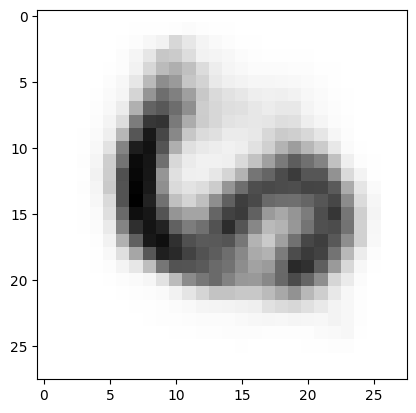

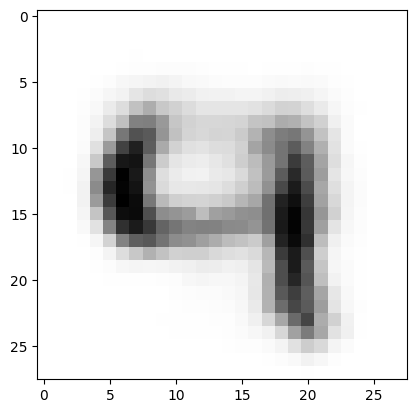

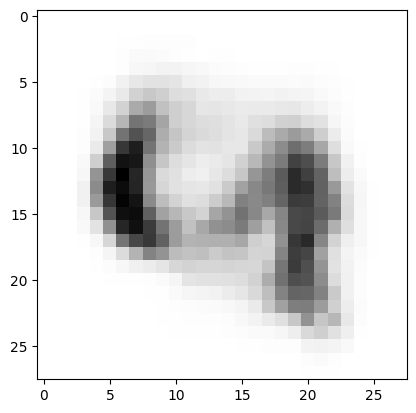

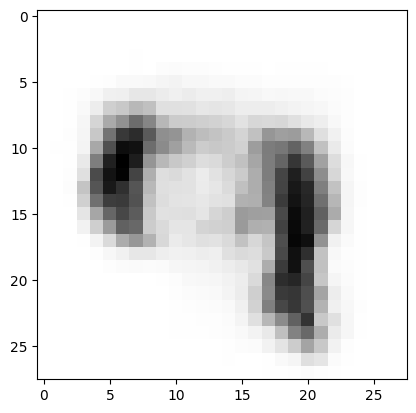

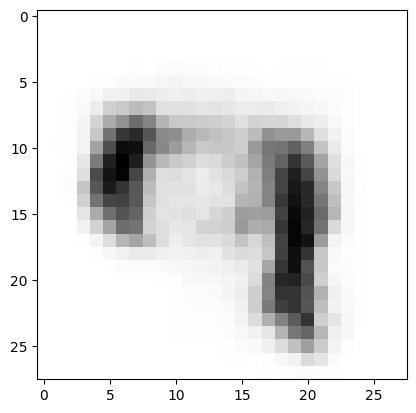

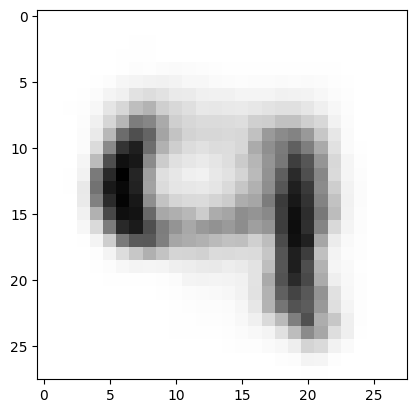

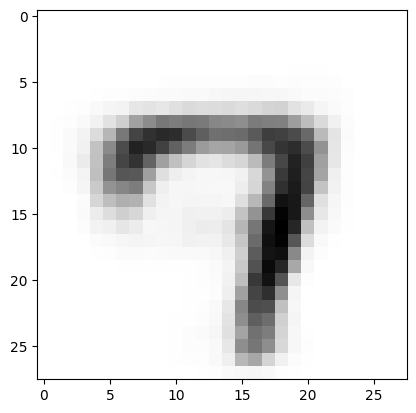

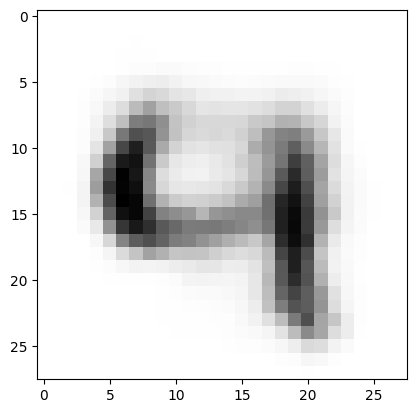

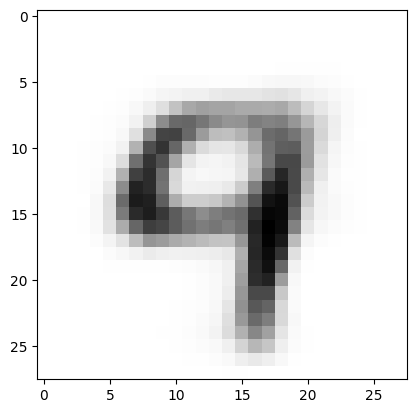

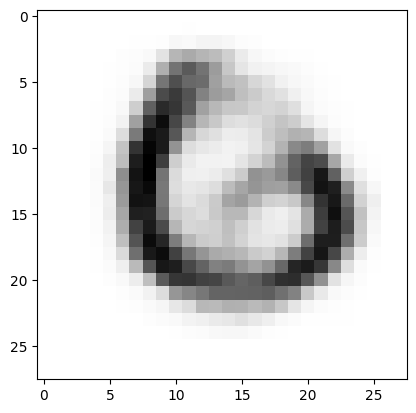

In [ ]:
decoder.eval()

with torch.no_grad():
    # you can try true samples
    # or useing argmax
    samples = decoder.sample_distributions(10)
    display_images(samples)

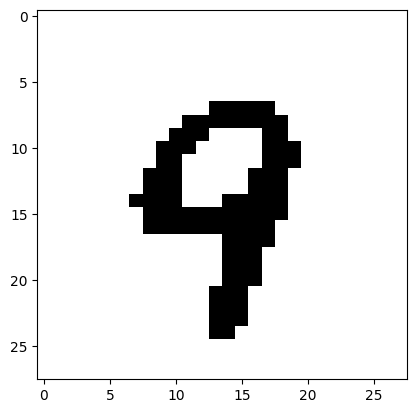

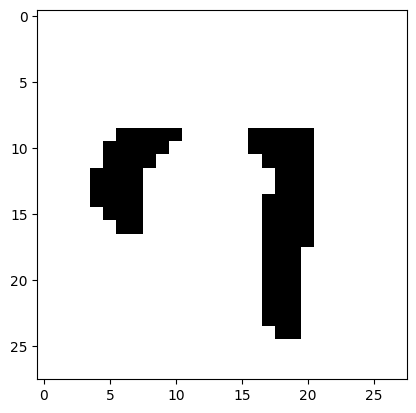

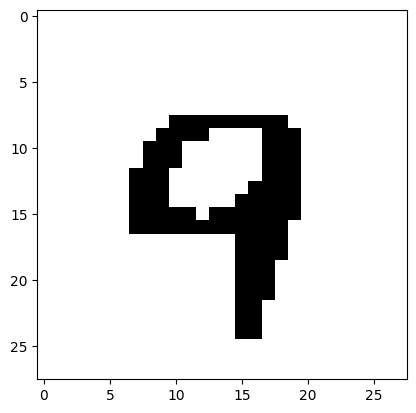

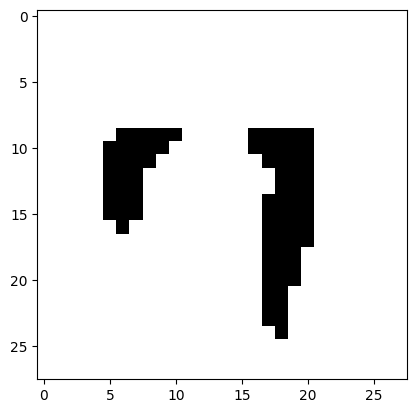

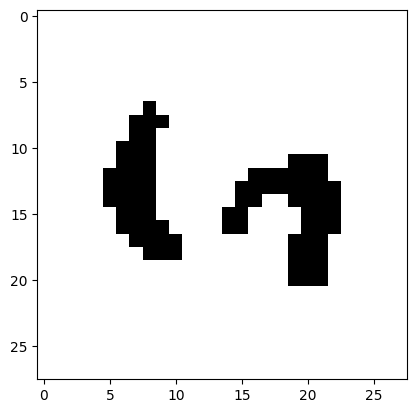

In [ ]:
decoder.eval()

with torch.no_grad():
    # you can try true samples
    # or useing argmax
    samples = decoder.sample_images(5, argmax=True)
    display_images(samples)

Using the approximate posterior, we can visualize the latent space, by assigning one color per digit.
What we display is the mean value.
For a well trained model, we should see all points close to 0 and each class should be well delimited, i.e. there must be clusters of the same color.

If your samples and latent space are ugly, you could try to improve your model by:

- change the learning hyperparameters
- add/remove dropout
- change the network structure (number and size of layers, dropout...)

Note that if you want to visualize a latent space when its dimension is greater than two, you could project it in 2 dimensions using PCA (its already implemented in scikit-learn!)

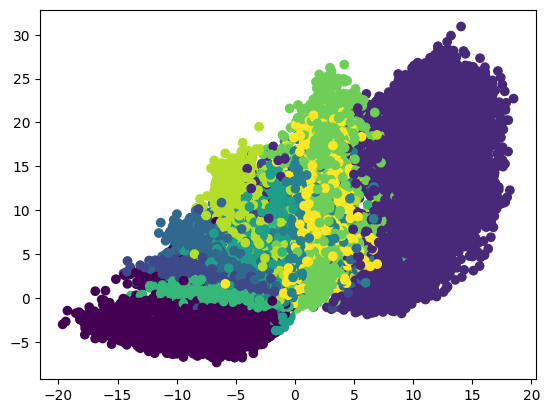

In [ ]:
decoder.eval()

# tensor that will contain all latent points
points = np.empty((train_data_pixels.shape[0], 2))
with torch.no_grad():
    for i in range(0, train_data_pixels.shape[0], batch_dim):
        batch = train_data_pixels[i:i+batch_dim]
        mu, _ = encoder(batch)
        points[i:i+batch_dim] = mu.numpy()

plt.scatter(
    points[:,0], points[:, 1],
    # colormap is between 0 and 1, and we have 10 classes
    # so we just divide by 10 :)
    # https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html
    #c=matplotlib.cm.get_cmap("tab10")(train_data_classes / 10.)
    c =train_data_classes
)
plt.show()

## 3. VAE with binary latent space and binary observed space

The second VAE that we will develop is based on the same generative story:

1. $z \sim p(z)$
2. $x \sim p(x | z ; \theta)$

but where the latent variable $Z$ are independent Bernoulli random variables.
See the last video from the course to understand how this change the model.

### Architecture

How many values should the encoder return? What is the difference with the previous encoder?

In [ ]:
class BernoulliEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.proj1 = nn.Linear(input_dim, hidden_dim)
        self.proj2 = nn.Linear(hidden_dim,hidden_dim)
        self.proj3 = nn.Linear(hidden_dim,output_dim)

    def forward(self, batch):
        hid = self.proj1(batch)
        hid = F.relu(hid)
        mu = self.proj3(hid)
        return mu

In [ ]:
class BernoulliPriorDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.proj1 = nn.Linear(input_dim, hidden_dim)
        self.proj2 = nn.Linear(hidden_dim, hidden_dim)
        self.proj3 = nn.Linear(hidden_dim, output_dim)
        self.input_dim = input_dim
        self.output_dim = output_dim

    def forward(self, batch):
        hid = self.proj1(batch)
        hid = F.relu(hid)
        return self.proj3(hid)

    def sample_distributions(self, n_samples):
        z = torch.empty(n_samples, self.input_dim).uniform_(0, 1)
        z=torch.bernoulli(z)
        res = self(z)
        sigmoid = nn.Sigmoid()
        return sigmoid(res)



    # sample images
    def sample_images(self, n_samples, argmax=False):
        probs = self.sample_distributions(n_samples)
        if argmax == False:
            return torch.bernoulli(probs)
        else:
            result = torch.zeros(probs.size(dim=0), probs.size(dim=1))
            for i in range(0, probs.size(dim=0)):
                for j in range(0, probs.size(dim=1)):
                    result[i, j] = 1*(probs[i,j].item() >= 0.5)
            return result

### KL divergence

We assume the prior are Bernoullis with parameter 0.5, i.e. the probability to sample 0 or 1 are equals ("fait coin" probability).
What the formula of the KL divergence? How does it simplify?

Hint: you should see an entropy term in it that you can compute via https://pytorch.org/docs/stable/distributions.html#torch.distributions.bernoulli.Bernoulli.entropy

KL formula :

$KL(p||q) = \sum_{j=1}^{J}p_{i,j}log(\frac{p_{i,j}}{q_{i,j}}) + (1-p_{i,j})log(\frac{1-p_{i,j}}{1-q_{i,j}})$ \\
In case of when q = 0.5 \\
$KL(p||q) = -\sum_{j=1}^{J}p_{i,j}log(\frac{0.5}{p_{i,j}}) + (1-p_{i,j})log(\frac{0.5}{1-p_{i,j}})$

In [ ]:
# the shapes of mu and log_sigma_squared are: (n batch, n latent)
# the return vector must be of shape: (n batch,)
import math
def KL_with_bernoulli_prior(probs):
    n = probs.size(dim=0);
    J = probs.size(dim=1);
    KL = torch.zeros(n);
    for i in range(0, n):
        s = 0;
        for j in range(0, J):
            # In the case if p = 1 or 0 we can't devide by 0 or do log(0)
            try :
              s -=  probs[i,j].item() * np.log(0.5/probs[i,j].item()) + (1-probs[i,j].item())*np.log((0.5)/(1-probs[i,j].item()))
            except :
              s -= np.log(0.5)
        KL[i] = s
    return KL

# test for shape
probs = torch.rand((10, 30))
if KL_with_bernoulli_prior(probs).shape != (10, ):
    raise RuntimeError("Invalid return dim!")
else:
    print("return dim is ok.")

# test for return value
# result should be 0 as it is equal to the prior
print("Should be 0:", KL_with_bernoulli_prior(torch.tensor([[0.5, 0.5]])).item())
print("Should be 0.693...:", KL_with_bernoulli_prior(torch.tensor([[1.]])).item())

return dim is ok.
Should be 0: 0.0
Should be 0.693...: 0.6931471824645996


### Training loop

This time I let you on your own!Â :)
Remember that you need to use the Score Function Estimator trick! (see the last video of the course)

You need to use a baseline to stabilize the variance of the estimator.
Here, we will rely on the average reconstruction value from all previous update.
You can easily store it and compute it using the running average trick:

In [ ]:
n1 = 5
n2 = 10
n3 = 1
n4 = 12

print((n1 + n2 + n3 + n4) / 4)

running_average = 0

# after the first parameter update
n_updates = 1
running_average += (n1 - running_average) / n_updates

# after the second parameter update
n_updates += 1
running_average += (n2 - running_average) / n_updates

# etc etc
n_updates += 1
running_average += (n3 - running_average) / n_updates

n_updates += 1
running_average += (n4 - running_average) / n_updates

# should be equal to the previous printed value!
print(running_average)

7.0
7.0


In [ ]:
dim_input = 28*28
latent = 2
#latent = 2     # For latent 2 for plot, the result isnt as good as more latent however it takes more time to compute
hidden_dim = 400
#n_epoch = 100
n_epoch = 20
batch_dim = 256

encoder = BernoulliEncoder(dim_input, hidden_dim, latent)
decoder = BernoulliPriorDecoder(latent, hidden_dim, dim_input)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))

running_avg = 0  # to control the variance of the SFE
n_updates = 0
for epoch in range(n_epoch):
    epoch_reconstruction = 0
    epoch_kl = 0

    decoder.train()
    encoder.train()
    for i in range(0, train_data_pixels.shape[0], batch_dim):
        optimizer.zero_grad()

        batch = train_data_pixels[i:i+batch_dim]

        # compute parameters of the approximate posterior
        mu= encoder(batch)
        sigmoid = nn.Sigmoid()
        mu1=sigmoid(mu)
        n = mu.size(dim=0)
        J = mu.size(dim=1)
        u= torch.rand(n,J)
        z= torch.zeros(n,J)

        for i in range(n):
          for j in range(J):
            z[i,j] = np.log(u[i,j].item()) - np.log(1-u[i,j].item()) + np.log(mu1[i,j].item()) - np.log(1-mu1[i,j].item())
        z = sigmoid(z)

        reconstruction_logits = decoder(z)
        reconstruction_loss = F.binary_cross_entropy_with_logits(
            reconstruction_logits,
            batch,
            reduction="none"
        )
        kl_div = KL_with_bernoulli_prior(mu1)
        # loss shape: (batch dim,)
        # do you understand why we sum along this dimension only?
        # there is a minus sign before reconstruction because
        # the loss formula is -log etc, but in the elbo its +log
        elbo = -reconstruction_loss.sum(1) - kl_div
        epoch_reconstruction += -reconstruction_loss.sum().item()
        epoch_kl += kl_div.sum().item()
        # we want to maximize the ELBO,
        # but Pytorch does minimization,
        # so we define our loss as -ELBO
        # and we mean over instances in the dataset

        loss = -elbo.mean()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5)
        optimizer.step()
        n_updates += 1

        # update the running_avg
        running_avg += (loss- running_avg) / n_updates


    print(
        epoch, ":\t",
        epoch_reconstruction / train_data_pixels.shape[0],
        "\t",
        epoch_kl / train_data_pixels.shape[0],
    )

KeyboardInterrupt: ignored

We can now visualize the trained model. :)

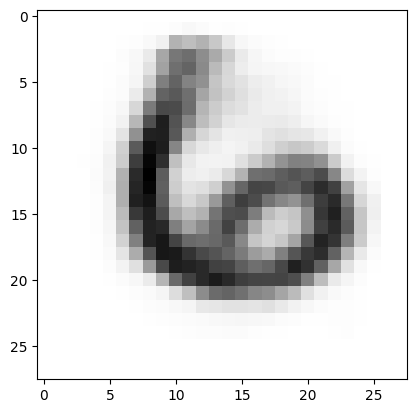

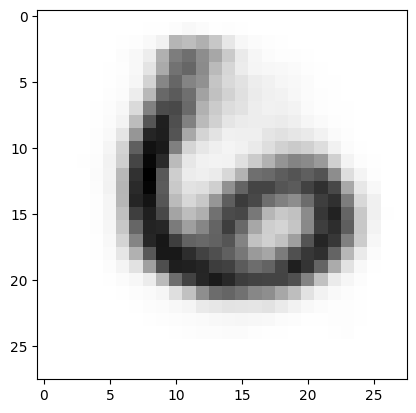

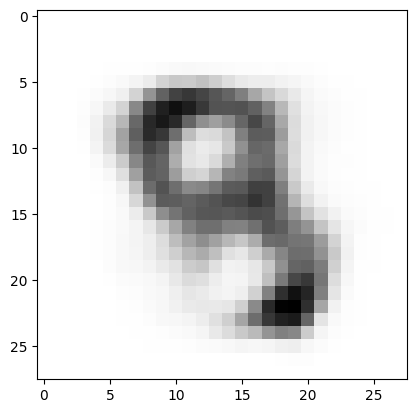

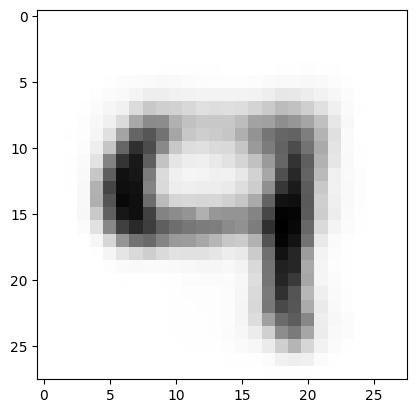

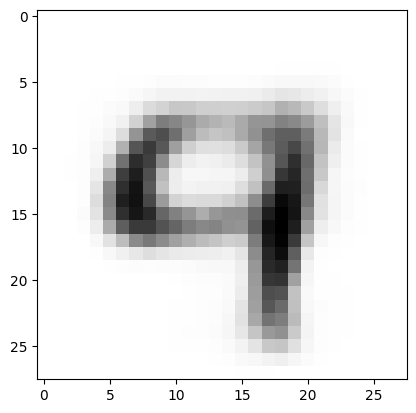

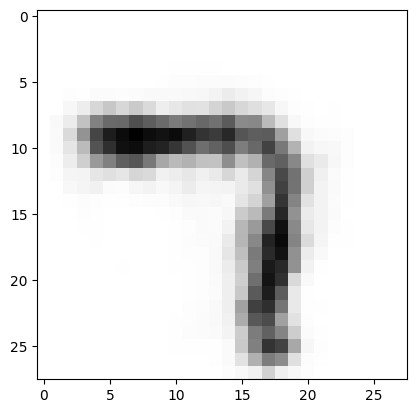

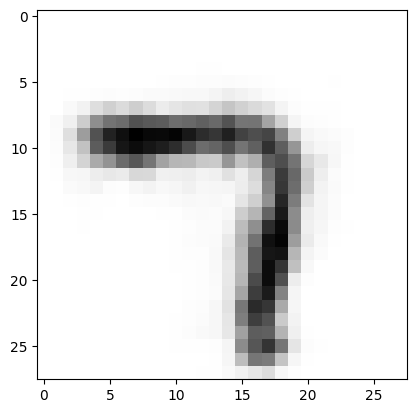

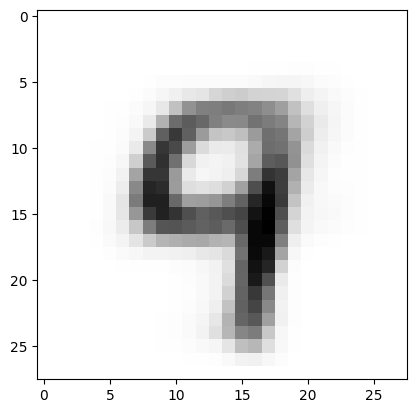

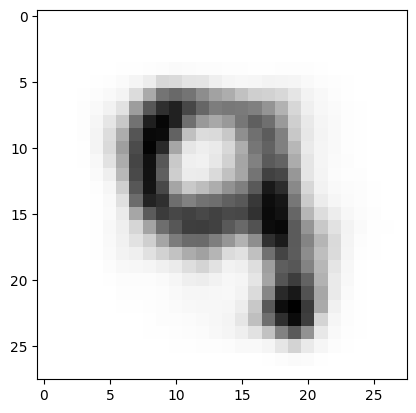

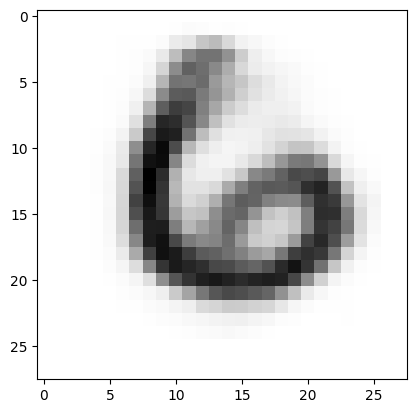

In [ ]:
decoder.eval()

with torch.no_grad():
    samples = decoder.sample_distributions(10)
    display_images(samples)

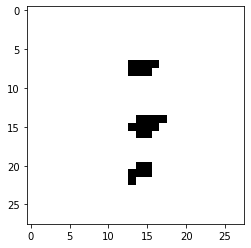

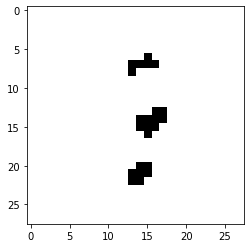

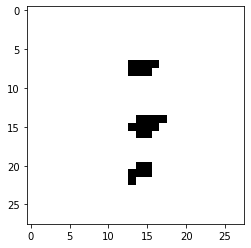

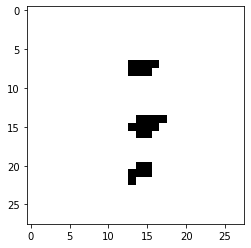

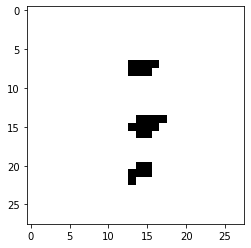

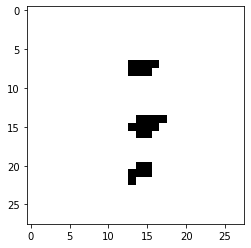

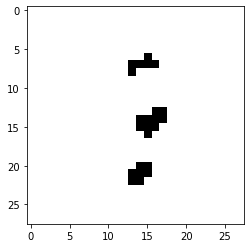

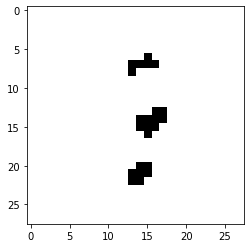

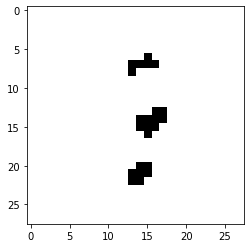

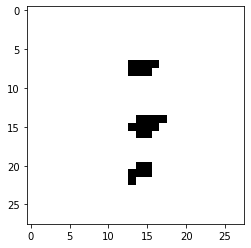

In [ ]:
decoder.eval()

with torch.no_grad():
    # you can try true samples
    # or useing argmax
    samples = decoder.sample_images(10, argmax=True)
    display_images(samples)

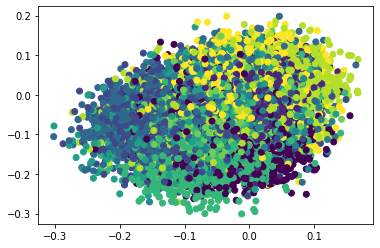

In [ ]:
decoder.eval()

# tensor that will contain all latent points
points = np.empty((train_data_pixels.shape[0], 2))
with torch.no_grad():
    for i in range(0, train_data_pixels.shape[0], batch_dim):
        batch = train_data_pixels[i:i+batch_dim]
        mu= encoder(batch)
        points[i:i+batch_dim] = mu.numpy()

plt.scatter(
    points[:,0], points[:, 1],
    # colormap is between 0 and 1, and we have 10 classes
    # so we just divide by 10 :)
    # https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html
    #c=matplotlib.cm.get_cmap("tab10")(train_data_classes / 10.)
    c =train_data_classes
)
plt.show()

#Â 4. Turning a Deterministic Auto-Encoder into a generative model

Last exercise!
Here I want to show you a trick to turn a deterministic model into a probabilistic generative model.
This a two step process.

First, you train an auto-encoder - not a VAE, just an encoder.
The encoder takes an image and project it in the latent space, here we will use a 2 dimension latent space.
It is a deterministic computation: the output of the encoder **is not** the parameters of the approximate posterior $q(z|x)$ distribution, it is a point in the $\mathbb R^2$ space.
The decoder reconstruct the input image from the encoder output.
Therefore, during training, the main difference is that you don't have a KL divergence term! :)

Second, we turn this deterministic model into a probabilistic generative model.
To do this, we look at where each training image of the training is mapped in the latent space.
You can train a Gaussian Mixture Model that will generate data that look like the latent space of the training set!
Then, to generate a new data point, you can:

1. sample a cluster from the GMM: $y \sim p(y)$
2. sample a point from the bivariate Gaussian associated with this cluster: $z \sim p(z|y)$
3. use the decoder to sample an image: $x \sim p(x | z)$

To fit and sample from the GMM, use the scikit learn library!
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

### Architecture and training loop of the auto-encoder

In [ ]:
from sklearn.mixture import GaussianMixture
import random

class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.proj1 = nn.Linear(input_dim, output_dim)

    def forward(self, batch):
        point = self.proj1(batch)
        return point

class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.proj1 = nn.Linear(input_dim, output_dim)
        self.input_dim = input_dim
        self.output_dim = output_dim

    def forward(self, batch):
        return self.proj1(batch)

    def sample_distributions(self, gmm, n_samples):
      # sample a cluster from the GMM (1 to 20)
      cluster = [random.randint(0, gmm.cluster-1) for iter in range(gmm.cluster)]

      # Get mean and sd about the chosen cluster

      mean_cluster = gmm.means[cluster]
      std_cluster = gmm.std[cluster]

      # Generate n_samples point from this
      z = torch.empty(torch.Size([n_samples,self.input_dim])).normal_(mean=0.,std=1.)
      for i in range(0, n_samples):
          for j in range(0, self.input_dim):
            z[i,j] = std_cluster[i].item() * z[i,j].item() + mean_cluster[i].item()

      # Decoder
      res = decoder(z)
      return sigmoid(res)


    # sample images
    def sample_images(self,gmm, n_samples, argmax=False):
        probs = self.sample_distributions(gmm,n_samples)
        if argmax == False:
            return torch.bernoulli(probs)
        else:
            result = torch.zeros(probs.size(dim=0), probs.size(dim=1))
            for i in range(0, probs.size(dim=0)):
                for j in range(0, probs.size(dim=1)):
                    result[i, j] = 1*(probs[i,j].item() >= 0.5)
            return result

class GMM(torch.nn.Module):

    def __init__(self, cluster):
        super().__init__()
        self.weights = torch.nn.Parameter(torch.ones(cluster, )) ## We can fix the weight to one for all, the result will be different and kinda worse but the number 0 is dominant
        self.means   = torch.nn.Parameter(torch.randn(cluster, ))
        self.std  = torch.nn.Parameter(torch.randn(cluster, ).abs())
        self.cluster = cluster

    def forward(self, x):
        mix  = torch.distributions.categorical.Categorical(self.weights.abs())
        comp = torch.distributions.normal.Normal(self.means, self.std.abs())
        gmm  = torch.distributions.mixture_same_family.MixtureSameFamily(mix, comp)
        return -gmm.log_prob(x).mean()

In [ ]:
dim_input = 28*28
latent_dim = 2
n_epoch = 80
batch_dim = 256
cluster = 20

encoder = Encoder(dim_input, latent_dim)
decoder = Decoder(latent_dim,dim_input)
gmm = GMM(cluster)
optimizer = torch.optim.Adam(list(gmm.parameters()) + list(decoder.parameters())  + list(encoder.parameters()))

for epoch in range(n_epoch):
    epoch_reconstruction = 0

    encoder.train()
    decoder.train()
    gmm.train()

    for i in range(0, train_data_pixels.shape[0], batch_dim):
        optimizer.zero_grad()

        batch = train_data_pixels[i:i+batch_dim]

        point = encoder(batch)

        reconstruction_logits = decoder(point)
        reconstruction_loss = F.binary_cross_entropy_with_logits(
            reconstruction_logits,
            batch,
            reduction="none"
        )

        # No KL

        loss = gmm(point) + reconstruction_loss.sum(1).mean()
        loss.backward()
        epoch_reconstruction += -reconstruction_loss.sum().item()
        # optimization trick :)
        # gradient clipping, so we don't take too big updates
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5)

        optimizer.step()

    print(
        epoch, ":\t",
        epoch_reconstruction / train_data_pixels.shape[0]
    )



0 :	 -485.62156734375
1 :	 -313.0689828125
2 :	 -218.0062803515625
3 :	 -205.8776588671875
4 :	 -202.729600859375
5 :	 -199.9010008203125
6 :	 -197.0616919140625
7 :	 -194.35519677734376
8 :	 -191.98083521484375
9 :	 -190.0259308984375
10 :	 -188.4540358984375
11 :	 -187.17713501953125
12 :	 -186.1096808203125
13 :	 -185.18812576171874
14 :	 -184.37200375
15 :	 -183.638296328125
16 :	 -182.97465525390626
17 :	 -182.373458984375
18 :	 -181.8304182421875
19 :	 -181.3424023046875
20 :	 -180.905923359375
21 :	 -180.5169769921875
22 :	 -180.17106447265624
23 :	 -179.8630127734375
24 :	 -179.58781921875
25 :	 -179.34098455078126
26 :	 -179.11870060546875
27 :	 -178.9178076171875
28 :	 -178.73573076171874
29 :	 -178.5702364453125
30 :	 -178.41967623046875
31 :	 -178.2825146484375
32 :	 -178.15742484375
33 :	 -178.0432081640625
34 :	 -177.9386337890625
35 :	 -177.84279798828126
36 :	 -177.754885234375
37 :	 -177.67420234375
38 :	 -177.60001837890624
39 :	 -177.531711484375
40 :	 -177.468642265

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Define your deterministic autoencoder architecture (encoder + decoder)
class DeterministicAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(DeterministicAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Sigmoid to squash output to [0, 1] for image reconstruction
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Set up your data loaders (assuming MNIST dataset for simplicity)
# transform = transforms.Compose([transforms.ToTensor(), transforms.Flatten()])
# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('./data', train=True, download=True, transform=transform),
#     batch_size=64, shuffle=True
# )

# Instantiate the deterministic autoencoder
latent_dim = 2  # Choose the dimensionality of the latent space
autoencoder = DeterministicAutoencoder(dim_input, hidden_dim,latent_dim)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for image reconstruction
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
n_epoch = 15
for epoch in range(n_epoch):
  for i in range(0, train_data_pixels.shape[0], batch_dim):
        optimizer.zero_grad()

        batch = train_data_pixels[i:i+batch_dim]

        optimizer.zero_grad()
        _, recon_batch = autoencoder(batch)
        loss = criterion(recon_batch, batch)
        loss.backward()
        optimizer.step()
  print(f'Epoch [{epoch+1}/{n_epoch}], Loss: {loss.item():.4f}')


Epoch [1/15], Loss: 0.2270
Epoch [2/15], Loss: 0.2139
Epoch [3/15], Loss: 0.2081
Epoch [4/15], Loss: 0.2038
Epoch [5/15], Loss: 0.2025
Epoch [6/15], Loss: 0.1995
Epoch [7/15], Loss: 0.1981
Epoch [8/15], Loss: 0.1968
Epoch [9/15], Loss: 0.1958
Epoch [10/15], Loss: 0.1948
Epoch [11/15], Loss: 0.1938
Epoch [12/15], Loss: 0.1928
Epoch [13/15], Loss: 0.1920
Epoch [14/15], Loss: 0.1918
Epoch [15/15], Loss: 0.1908


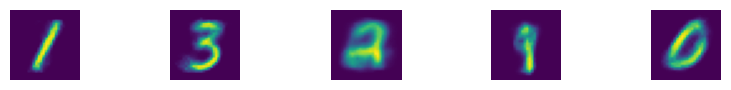

In [ ]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np

# Extract the latent space representations for all training data
latent_space = []
for i in range(0, train_data_pixels.shape[0], batch_dim):
    data =  train_data_pixels[i:i+batch_dim]
    encoded, _ = autoencoder(data)
    latent_space.append(encoded.detach().numpy())
latent_space = np.concatenate(latent_space, axis=0)

# Fit a Gaussian Mixture Model (GMM) to the latent space
n_components = 10  # Choose the number of components (clusters)
gmm = GaussianMixture(n_components=n_components, random_state=0)
gmm.fit(latent_space)

# Sample from the GMM
n_samples = 5
cluster_samples = gmm.sample(n_samples)[0]

# Decode samples from the GMM
decoded_samples = autoencoder.decoder(torch.tensor(cluster_samples, dtype=torch.float32)).detach().numpy()

# Plot the decoded samples
plt.figure(figsize=(10, 2))
for i in range(n_samples):
    plt.subplot(2, n_samples, i + 1)
    plt.imshow(decoded_samples[i].reshape(28, 28), cmap='grey')
    plt.axis('off')
plt.show()


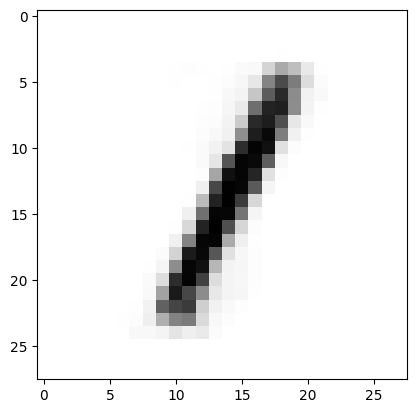

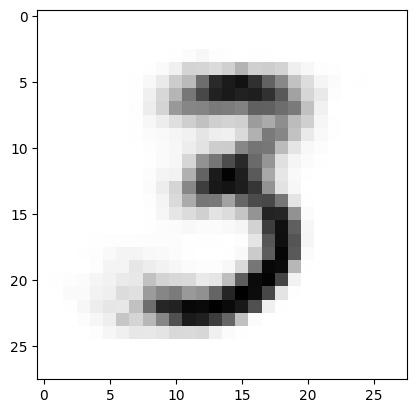

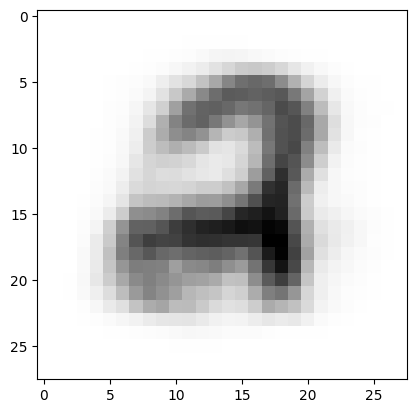

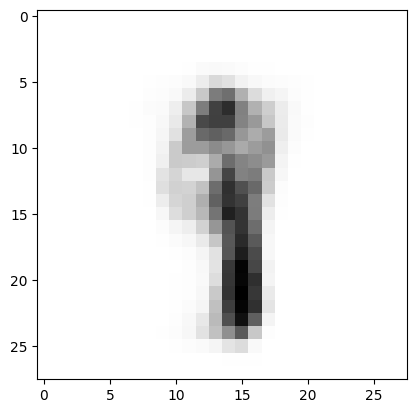

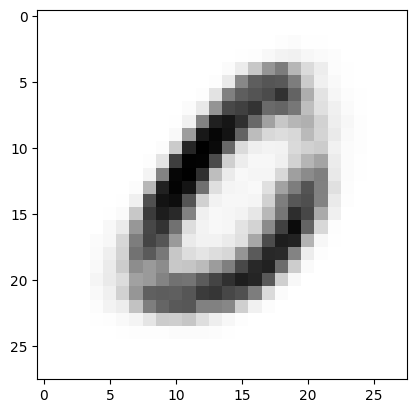

In [ ]:
decoder.eval()
with torch.no_grad():
    # you can try true samples
    # or useing argmax
    display_images(torch.from_numpy(decoded_samples))

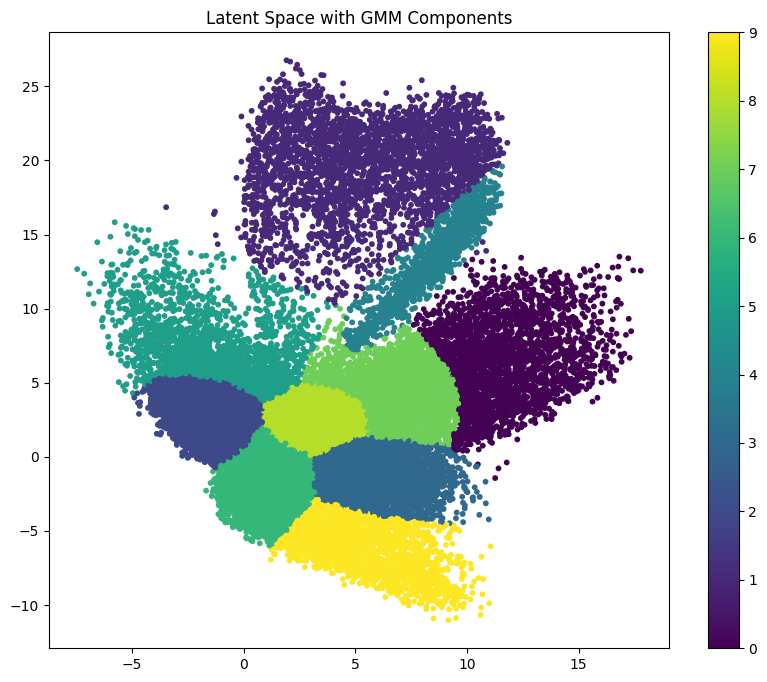

In [ ]:
# Plot the latent space points with color-coded GMM components
plt.figure(figsize=(10, 8))
plt.scatter(latent_space[:, 0], latent_space[:, 1], c=gmm.predict(latent_space), cmap='viridis', s=10)
plt.title('Latent Space with GMM Components')
plt.colorbar()
plt.show()

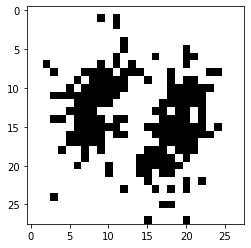

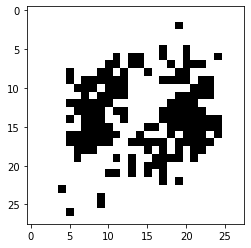

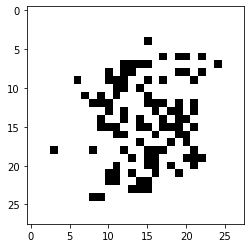

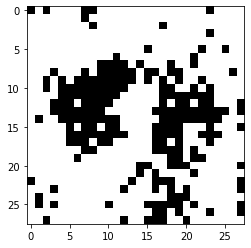

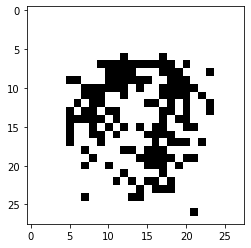

In [ ]:
decoder.eval()

with torch.no_grad():
    samples = decoder.sample_images(gmm,5)
    display_images(samples)

We can now visualize the latent space of the deterministic auto-encoder. How does it look like compared to the VAE one? Does it looks like we can fit it with a GMM?

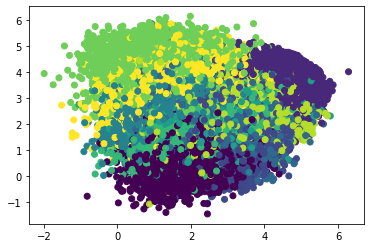

In [ ]:
decoder.eval()

# tensor that will contain all latent points
points = np.empty((train_data_pixels.shape[0], 2))
with torch.no_grad():
    for i in range(0, train_data_pixels.shape[0], batch_dim):
        batch = train_data_pixels[i:i+batch_dim]
        mu= encoder(batch)
        points[i:i+batch_dim] = mu.numpy()

plt.scatter(
    points[:,0], points[:, 1],
    # colormap is between 0 and 1, and we have 10 classes
    # so we just divide by 10 :)
    # https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html
    #c=matplotlib.cm.get_cmap("tab10")(train_data_classes / 10.)
    c =train_data_classes
)
plt.show()

### Turning the deterministic auto-encoder into a generative model

Todo:

1. fit the point from the encoder with a GMM (for example with 20 clusters, called components in scikit-learn): https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
2. Sample many points from this GMM and plot them: does the resulting point cloud looks like the one above? (or, in other words, did the GMMÂ correctly fit the latent space?)
3. Sample new data from the model! How does it looks like compared to VAE? how does the output distribution looks like? Does it work?

Note: its an **unsupervised problem**, do not use class information in this part!

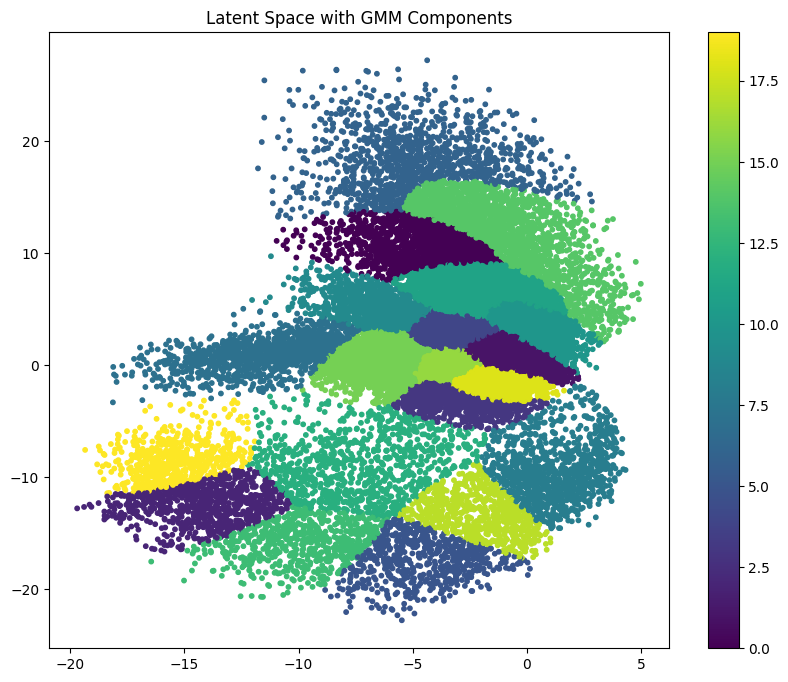

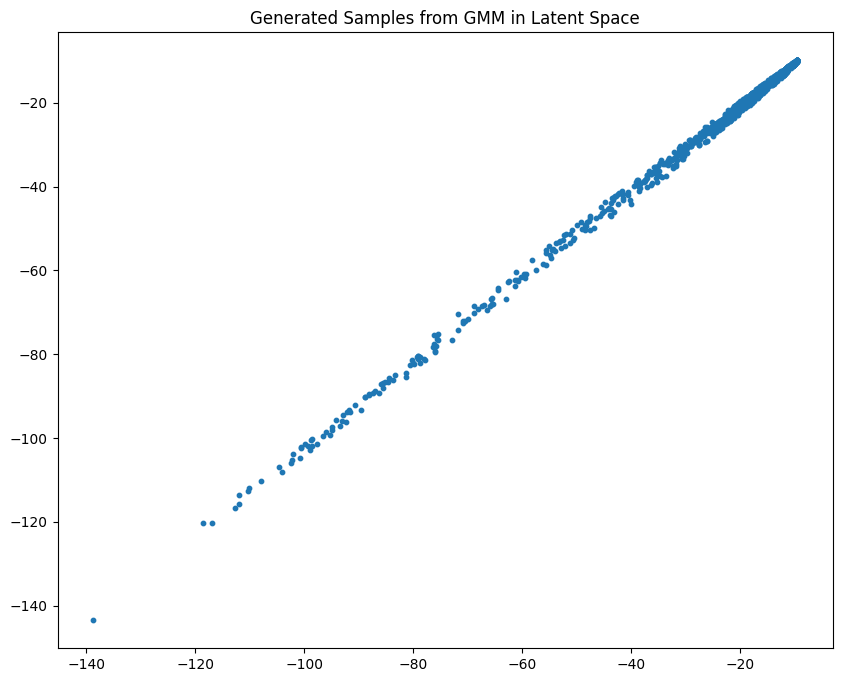

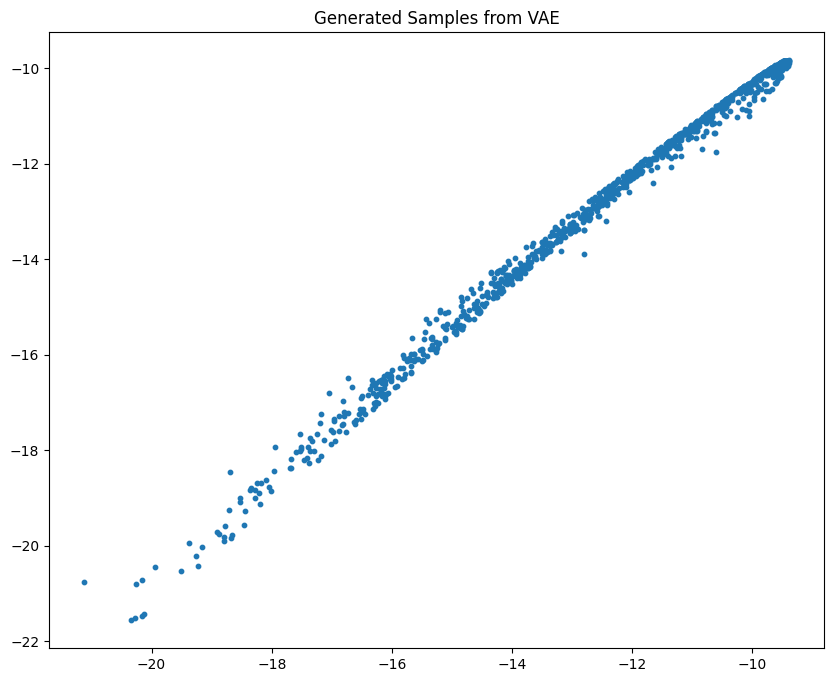

In [ ]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the trained VAE and data
# encoder and decoder are your trained VAE encoder and decoder models
# train_data_pixels is your training data

# Set the number of components for the GMM
n_components = 20

# Encode the training data using the VAE encoder
encoded_data = encoder(train_data_pixels)

# Extract mean and log variance from the tuple output
mu, log_sigma_squared = encoded_data

# Combine mean and log variance to get the standard deviation
sigma = torch.exp(0.5 * log_sigma_squared)

# Create a tensor of shape (batch_size, latent_dim) to sample from the normal distribution
z = mu + sigma * torch.randn_like(mu)
z=z.detach().numpy()
# Convert to numpy for GMM fitting
encoded_data_np = z

# Fit a Gaussian Mixture Model to the encoded data
gmm = GaussianMixture(n_components=n_components, random_state=0)
gmm.fit(encoded_data_np)

# Plot the latent space points with color-coded GMM components
plt.figure(figsize=(10, 8))
plt.scatter(z[:, 0], z[:, 1], c=gmm.predict(encoded_data_np), cmap='viridis', s=10)
plt.title('Latent Space with GMM Components')
plt.colorbar()
plt.show()

# Sample many points from the GMM
generated_samples, _ = gmm.sample(1000)

# Decode the generated samples using the VAE decoder
generated_samples = torch.from_numpy(generated_samples)
generated_samples = generated_samples.type(torch.float32)
decoded_samples = decoder(generated_samples).detach().numpy()

# Plot the generated samples
plt.figure(figsize=(10, 8))
plt.scatter(decoded_samples[:, 0], decoded_samples[:, 1], s=10)
plt.title('Generated Samples from GMM in Latent Space')
plt.show()

# Sample new data from the VAE
n_samples_vae = 1000
z_vae = torch.randn(n_samples_vae, latent_dim)
generated_samples_vae = decoder(z_vae).detach().numpy()

# Plot the generated samples from the VAE
plt.figure(figsize=(10, 8))
plt.scatter(generated_samples_vae[:, 0], generated_samples_vae[:, 1], s=10)
plt.title('Generated Samples from VAE')
plt.show()
